# 11 数据分析案例

In [50]:
import pandas as pd
import numpy as np
from datetime import datetime

# 导入matplotlib库中的额pyplot
import matplotlib.pyplot as plt
# 让图表直接在Jupyter notebook中展示出来
%matplotlib inline
# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号无法正常显示的问题
plt.rcParams['axes.unicode_minus'] = False
# 默认设置下matplotlib做出来的图标不是很清晰，可以将图表设置成矢量格式显示
%config InlineBackend.figure_format = 'svg'

# 一个cell输出多行语句
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 一、利用Python实现报表自动化
数据分析师 vs "表哥"

### 1.1 为什么要进行报表自动化
* 提高工作效率
* 减少错误

### 1.2 什么样的报表适合自动化
* 使用频率较高，如：日报、周报、月报
* 开发时间长短
* 需求变更频率高
* 流程标准

### 1.3 案例说明
假如你现在每天需要做一个表，这个表包括销售额、客流量、客单价这个三个指标的本月累计、上月同期、去年同期、环比、同比这几个指标

<img src='./image/case1_1.jpg' width='60%' />

做报表的源数据存放在一张订单表里面，包含了从去年至今的所有订单数据

<img src='./image/case1_2.jpg' width='60%' />

指标说明：
* 销售额 = 单价*销量
* 客流量 = 订单ID去重计数
* 客单价 = 销售额/客流量
* 本月 = 2018年2月
* 上月 = 2018年1月
* 去年同期 = 2017年2月

In [51]:
# parse_dates：将数据解析为时间格式
data = pd.read_csv('./data/order-14.1.csv', parse_dates=['成交时间'], encoding='gbk')
data.head()
data.info()

,商品ID,类别ID,门店编号,单价,销量,成交时间,订单ID
0,30006206.0,915000003.0,CDNL,25.23,0.328,2018-01-01,20170103CDLG000210052759
1,30163281.0,914010000.0,CDNL,2.00,2.000,2018-01-02,20170103CDLG000210052759
2,30200518.0,922000000.0,CDNL,19.62,0.230,2018-01-03,20170103CDLG000210052759
3,29989105.0,922000000.0,CDNL,2.80,2.044,2018-01-04,20170103CDLG000210052759
4,30179558.0,915000100.0,CDNL,47.41,0.226,2018-01-05,20170103CDLG000210052759


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 7 columns):
商品ID    3478 non-null float64
类别ID    3478 non-null float64
门店编号    3478 non-null object
单价      3478 non-null float64
销量      3478 non-null float64
成交时间    3478 non-null datetime64[ns]
订单ID    3478 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 204.9+ KB


In [52]:
# 计算本月相关指标
# 本月数据
month_this = data[(data['成交时间'] >= datetime(2018, 2, 1)) & (data['成交时间'] <= datetime(2018, 2, 28))]
# 本月销售额
sales_this = (month_this['销量']*month_this['单价']).sum()
# 客流量
traffic_this = month_this['订单ID'].drop_duplicates().count()
# 客单价计算
s_t_this = sales_this/traffic_this
sales_this
traffic_this
s_t_this

10412.78007

343

30.357959387755105

In [53]:
# 计算上月相关指标
month_pre = data[(data['成交时间'] >= datetime(2018, 1, 1)) & (data['成交时间'] <= datetime(2018, 1, 31))]
sales_pre = (month_pre['销量']*month_pre['单价']).sum()
# 客流量
traffic_pre = month_pre['订单ID'].drop_duplicates().count()
# 客单价计算
s_t_pre = sales_pre/traffic_pre
sales_pre
traffic_pre
s_t_pre

9940.97291

315

31.55864415873016

In [54]:
def get_month_data(data):
    # 本月销售额
    sales = (data['销量']*data['单价']).sum()
    # 客流量
    traffic = data['订单ID'].drop_duplicates().count()
    # 客单价计算
    s_t = sales/traffic
    return (sales, traffic, s_t)

month_last_year = data[(data['成交时间'] >= datetime(2017, 2, 1)) & (data['成交时间'] <= datetime(2017, 2, 28))]
sales_this, traffic_this, s_t_this = get_month_data(month_this)
sales_pre, traffic_pre, s_t_pre = get_month_data(month_pre)
sales_last_year, traffic_last_year, s_t_last_year = get_month_data(month_last_year)

report = pd.DataFrame([[sales_this, sales_pre, sales_last_year], 
                       [traffic_pre, traffic_pre, traffic_last_year], 
                       [s_t_pre, s_t_pre, s_t_last_year]],
                     columns=['本月累计', '上月同期', '去年同期'],
                     index=['销售额', '客流量', '客单价'])
report

,本月累计,上月同期,去年同期
销售额,10412.780070,9940.972910,8596.313470
客流量,315.000000,315.000000,262.000000
客单价,31.558644,31.558644,32.810357


In [55]:
# 添加同比与环比
report['环比'] = report['本月累计'] / report['上月同期'] - 1
report['同比'] = report['本月累计'] / report['去年同期'] - 1
report

,本月累计,上月同期,去年同期,环比,同比
销售额,10412.780070,9940.972910,8596.313470,0.047461,0.211308
客流量,315.000000,315.000000,262.000000,0.000000,0.202290
客单价,31.558644,31.558644,32.810357,0.000000,-0.038150


In [56]:
# 导出结果
report.to_excel('./data/order-report.xlsx', encoding='utf-8')

## 二、自动发送邮件
报表做出来后要发送给老板看，每天自动发送邮件

In [57]:
import smtplib
from email import encoders
from email.header import Header
from email.mime.text import MIMEText
from email.utils import parseaddr, formataddr
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart

# 发件人邮箱
asender = 'liupan6888@163.com'
# 收件人邮箱
areceiver = 'liupan6888@163.com'
# 抄送人邮箱
acc = 'liupan6888@163.com'
# 邮件主题
asubject = '这是一份测试邮件'

# 发件人地址
from_addr = 'liupan6888@163.com'
# 密码
password = 'silian1878'

# 邮件设置
msg = MIMEMultipart()
msg['Subject'] = asubject
msg['to'] = areceiver
msg['Cc'] = acc
msg['from'] = '张三'

# 正文
body = '您好，这是一份测试邮件'

# 添加邮件正文
msg.attach(MIMEText(body, 'plain', 'utf-8'))

# 添加附件
xlsxpart = MIMEApplication(open('./data/order-report.xlsx', 'rb').read())
xlsxpart.add_header('Content-Disposition', 'attachment', filename='订单销售分析报告.xlsx')
msg.attach(xlsxpart)

# 设置邮箱服务器地址及端口
smtp_server = 'smtp.163.com'
server = smtplib.SMTP(smtp_server, 25)
server.set_debuglevel(1)
# 登录邮箱
server.login(from_addr, password)
# 发送邮件
server.sendmail(from_addr, areceiver.split(',')+acc.split(','),
               msg.as_string())

server.quit()

send: 'ehlo pandeMacBook-Pro.local\r\n'
reply: b'250-mail\r\n'
reply: b'250-PIPELINING\r\n'
reply: b'250-AUTH LOGIN PLAIN\r\n'
reply: b'250-AUTH=LOGIN PLAIN\r\n'
reply: b'250-coremail 1Uxr2xKj7kG0xkI17xGrU7I0s8FY2U3Uj8Cz28x1UUUUU7Ic2I0Y2UFyN8wFUCa0xDrUUUUj\r\n'
reply: b'250-STARTTLS\r\n'
reply: b'250 8BITMIME\r\n'
reply: retcode (250); Msg: b'mail\nPIPELINING\nAUTH LOGIN PLAIN\nAUTH=LOGIN PLAIN\ncoremail 1Uxr2xKj7kG0xkI17xGrU7I0s8FY2U3Uj8Cz28x1UUUUU7Ic2I0Y2UFyN8wFUCa0xDrUUUUj\nSTARTTLS\n8BITMIME'
send: 'AUTH PLAIN AGxpdXBhbjY4ODhAMTYzLmNvbQBzaWxpYW4xODc4\r\n'
reply: b'235 Authentication successful\r\n'
reply: retcode (235); Msg: b'Authentication successful'


(235, b'Authentication successful')

send: 'mail FROM:<liupan6888@163.com>\r\n'
reply: b'250 Mail OK\r\n'
reply: retcode (250); Msg: b'Mail OK'
send: 'rcpt TO:<liupan6888@163.com>\r\n'
reply: b'250 Mail OK\r\n'
reply: retcode (250); Msg: b'Mail OK'
send: 'rcpt TO:<liupan6888@163.com>\r\n'
reply: b'250 Mail OK\r\n'
reply: retcode (250); Msg: b'Mail OK'
send: 'data\r\n'
reply: b'354 End data with <CR><LF>.<CR><LF>\r\n'
reply: retcode (354); Msg: b'End data with <CR><LF>.<CR><LF>'
data: (354, b'End data with <CR><LF>.<CR><LF>')
send: b'Content-Type: multipart/mixed; boundary="===============7283546143277177108=="\r\nMIME-Version: 1.0\r\nSubject: =?utf-8?b?6L+Z5piv5LiA5Lu95rWL6K+V6YKu5Lu2?=\r\nto: liupan6888@163.com\r\nCc: liupan6888@163.com\r\nfrom: =?utf-8?b?5byg5LiJ?=\r\n\r\n--===============7283546143277177108==\r\nContent-Type: text/plain; charset="utf-8"\r\nMIME-Version: 1.0\r\nContent-Transfer-Encoding: base64\r\n\r\n5oKo5aW977yM6L+Z5piv5LiA5Lu95rWL6K+V6YKu5Lu2\r\n\r\n--===============7283546143277177108==\r\nContent-T

{}

send: 'quit\r\n'
reply: b'221 Bye\r\n'
reply: retcode (221); Msg: b'Bye'


(221, b'Bye')

## 三、假如你是某连锁超市的数据分析师
### 3.1 哪些类别的商品比较畅销

In [79]:
data = pd.read_csv('./data/order-14.3.csv', parse_dates=['成交时间'], encoding='gbk')
data.head()
data.info()
# 数据分组
data.groupby('类别ID')['销量'].sum().reset_index().sort_values(by='销量', ascending=False)
data.groupby('类别ID')['销量'].sum().sort_values(ascending=False).reset_index()

,商品ID,类别ID,门店编号,单价,销量,成交时间,订单ID
0,30006206,915000003,CDNL,25.23,0.328,2017-01-03 09:56:00,20170103CDLG000210052759
1,30163281,914010000,CDNL,2.00,2.000,2017-01-03 09:56:00,20170103CDLG000210052759
2,30200518,922000000,CDNL,19.62,0.230,2017-01-03 09:56:00,20170103CDLG000210052759
3,29989105,922000000,CDNL,2.80,2.044,2017-01-03 09:56:00,20170103CDLG000210052759
4,30179558,915000100,CDNL,47.41,0.226,2017-01-03 09:56:00,20170103CDLG000210052759


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3478 entries, 0 to 3477
Data columns (total 7 columns):
商品ID    3478 non-null int64
类别ID    3478 non-null int64
门店编号    3478 non-null object
单价      3478 non-null float64
销量      3478 non-null float64
成交时间    3478 non-null datetime64[ns]
订单ID    3478 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 190.3+ KB


,类别ID,销量
240,922000003,425.328
239,922000002,206.424
251,923000006,190.294
216,915030104,175.059
238,922000001,121.355
...,...,...
218,915030204,0.215
111,912060605,0.193
201,915000102,0.110
304,931000200,0.000


,类别ID,销量
0,922000003,425.328
1,922000002,206.424
2,923000006,190.294
3,915030104,175.059
4,922000001,121.355
...,...,...
363,915030204,0.215
364,912060605,0.193
365,915000102,0.110
366,931000200,0.000


### 3.2 哪些商品比较畅销

In [80]:
# 数据透视表
pd.pivot_table(data, index='商品ID', values='销量', aggfunc='sum').sort_values(by='销量', ascending=False)

,销量
商品ID,
29989059,391.549
29989072,102.876
30022232,101.000
30031960,99.998
29989157,72.453
...,...
30214826,0.073
30179536,0.040
30156418,0.000


### 3.3 不同门店的销售额占比

门店编号
CDLG    10908.82612
CDNL     8059.47867
CDXL     9981.76166
Name: 销售额, dtype: float64

门店编号
CDLG    0.376815
CDNL    0.278392
CDXL    0.344792
Name: 销售额, dtype: float64

numpy.ndarray

([<matplotlib.patches.Wedge at 0x11efccdd0>,
 [Text(0.41514948122654655, 1.0186515146198574, 'CDLG'),
  Text(-1.0944381861745864, -0.11047649814726032, 'CDNL'),
  Text(0.5153568158113694, -0.971806231919083, 'CDXL')],
 [Text(0.22644517157811628, 0.5556280988835585, '38%'),
  Text(-0.5969662833679561, -0.060259908080323804, '28%'),
  Text(0.28110371771529236, -0.530076126501318, '34%')])

Text(0.5, 1.0, '不同门店的销售额占比')

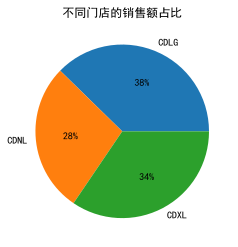

In [81]:
data['销售额'] = data['销量'] * data['单价']
data.groupby('门店编号')['销售额'].sum()
data.groupby('门店编号')['销售额'].sum() / data['销售额'].sum()
# (data.groupby('门店编号')['销售额'].sum() / data['销售额'].sum()).plot.pie()


d = data.groupby('门店编号')['销售额'].sum() / data['销售额'].sum()
type(d.index.values)
plt.subplot(1, 1, 1)
plt.pie(x=d.values, labels=d.index.values, autopct='%.0f%%')
plt.title('不同门店的销售额占比')

### 3.4 哪些时间段是超市的客流高峰
了解清楚哪些时段是超市客流的高峰期很必要，可以帮助超市管理人员提前布置工作人员，决定在什么时段开展促销活动。

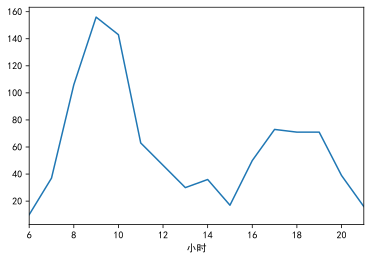

In [82]:
# 利用自定义时间格式函数strftime提取小时数
data['小时'] = data['成交时间'].map(lambda x:int(x.strftime('%H')))
# 对小时和订单去重
traffic = data[['小时', '订单ID']].drop_duplicates()
# 求每小时的客流量
traffic.groupby('小时')['订单ID'].count().plot()

## 四、假如你是某银行的数据分析师
加入你是某银行的数据分析师，坏账率是你日常关注的重点指标，坏账率受哪些因素的影响呢？现有一份历史人员借款表。分析一下受哪些因素影响

注：坏账率：所有借款用户中逾期不还用户的占比，逾期不还用户好坏客户字段标记为1，反之标记为0

In [83]:
data = pd.read_csv('./data/loan.csv', encoding='gbk')
data.head()
data.info()

,用户ID,好坏客户,年龄,负债率,月收入,家属数量
0,1,1,45,0.802982,9120.0,2.0
1,2,0,40,0.121876,2600.0,1.0
2,3,0,38,0.085113,3042.0,0.0
3,4,0,30,0.036050,3300.0,0.0
4,5,0,49,0.024926,63588.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 6 columns):
用户ID    150000 non-null int64
好坏客户    150000 non-null int64
年龄      150000 non-null int64
负债率     150000 non-null float64
月收入     120269 non-null float64
家属数量    146076 non-null float64
dtypes: float64(3), int64(3)
memory usage: 6.9 MB


### 4.1 是不是收入越高的人坏账率越低？
按理说收入越高，越不缺钱，坏账率应该越低，是不是这样的呢？

收入的缺失值处理，使用均值来填充

In [84]:
data = data.fillna({'月收入': data['月收入'].mean()})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 6 columns):
用户ID    150000 non-null int64
好坏客户    150000 non-null int64
年龄      150000 non-null int64
负债率     150000 non-null float64
月收入     150000 non-null float64
家属数量    146076 non-null float64
dtypes: float64(3), int64(3)
memory usage: 6.9 MB


In [85]:
# 因为月收入属于连续值，对于连续值进行分析时，一般会将连续值离散化，即将连续值进行区间划分，分成若干个类
cut_bins = [0, 5000, 10000, 15000, 20000, 100000]
income_cut = pd.cut(data['月收入'], cut_bins)
income_cut

0           (5000, 10000]
1               (0, 5000]
2               (0, 5000]
3               (0, 5000]
4         (20000, 100000]
               ...       
149995          (0, 5000]
149996      (5000, 10000]
149997      (5000, 10000]
149998      (5000, 10000]
149999      (5000, 10000]
Name: 月收入, Length: 150000, dtype: category
Categories (5, interval[int64]): [(0, 5000] < (5000, 10000] < (10000, 15000] < (15000, 20000] < (20000, 100000]]

In [86]:
all_income_user = data['好坏客户'].groupby(income_cut).count()
bad_income_user = data['好坏客户'].groupby(income_cut).sum()
bad_rate = bad_income_user / all_income_user
bad_rate

月收入
(0, 5000]          0.087543
(5000, 10000]      0.058308
(10000, 15000]     0.041964
(15000, 20000]     0.041811
(20000, 100000]    0.053615
Name: 好坏客户, dtype: float64

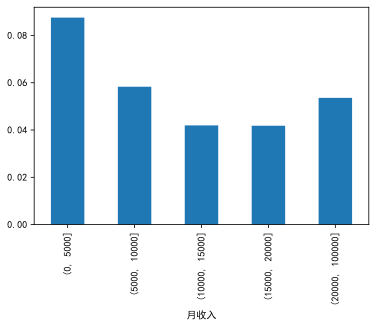

In [87]:
bad_rate.plot.bar()

### 4.2 年龄和坏账率有什么关系？
是不是年龄越大越理性，对信用越看重，坏账率更低呢？

年龄
(-0.109, 18.167]    0.000000
(18.167, 36.333]    0.110124
(36.333, 54.5]      0.081645
(54.5, 72.667]      0.041719
(72.667, 90.833]    0.021585
(90.833, 109.0]     0.022495
Name: 好坏客户, dtype: float64

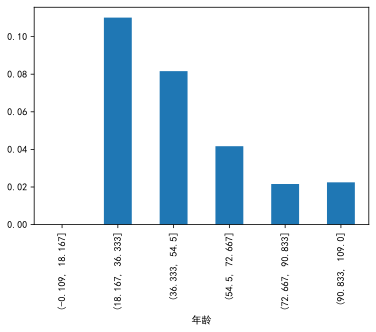

In [89]:
age_cut = pd.cut(data['年龄'], 6)
all_age_user = data['好坏客户'].groupby(age_cut).count()
bad_age_user = data['好坏客户'].groupby(age_cut).sum()
bad_rate = bad_age_user / all_age_user
bad_rate
bad_rate.plot.bar()

### 4.3 家庭人口数量和坏账率有什么关系？
是家庭人口越多，负担越重，坏账率越高？还是家庭人口越多，劳动力越多，坏账率越低呢？

家属数量
0.0     0.058629
1.0     0.073529
2.0     0.081139
3.0     0.088263
4.0     0.103774
5.0     0.091153
6.0     0.151899
7.0     0.098039
8.0     0.083333
9.0     0.000000
10.0    0.000000
13.0    0.000000
20.0    0.000000
Name: 好坏客户, dtype: float64

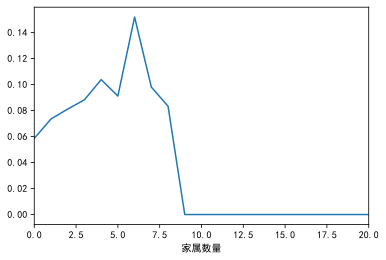

In [92]:
all_family_user = data.groupby('家属数量')['好坏客户'].count()
bad_family_user = data.groupby('家属数量')['好坏客户'].sum()
bad_rate = bad_family_user / all_family_user
bad_rate
bad_rate.plot()